In [1]:
import matplotlib.pyplot as plt
import torch
import argparse
import json

import numpy as np
from multiprocessing import Pool

from OcpDefinition import OcpDefinition
from Parameters import Parameters
from Critic.Model import Critic

In [2]:
N = 50          # horizon size
dt = 0.1        # time step
w_u = 1e-2
u_min = -1      # min control input
u_max = 1       # max control input
PLOT = False
SAMPLES = 1000
x_range = [-3, 3]

# folder = "critic_runs/critic_v5_500_v2_00003_20250112_211758/"

In [3]:
def solveOneProblem(params: Parameters):
    ocp = OcpDefinition(params.dt, params.w_u, params.u_min, params.u_max)
    sol = ocp.solve(params.x_init, params.N)
    return params.x_init, sol[0]

def generate_initial_states(num_samples, x_range):
    return np.random.uniform(x_range[0], x_range[1], num_samples)

### Generate a Validation dataset of solutions from initial states

## Initialize Critic and run model on initial states

In [4]:
def evalCriticModel(folder, version, test_buffer):
    critic = Critic(version).to('cuda')
    critic.load_state_dict(torch.load(folder + '/model.pt', weights_only=True))
    critic.eval()


    # Predict V using Critic
    with torch.no_grad():
        x_test = torch.tensor([item[0] for item in test_buffer], dtype=torch.float32).to('cuda').unsqueeze(1)
        V_pred = critic(x_test).cpu().squeeze().numpy()
    
    return V_pred

## Plot Results

In [5]:
def plotResults(V_pred, V_true, losses):
    # Create a plot that contains both the losses and the critic performance
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    # Plot Critic performance
    plt.scatter(V_true, V_pred)
    plt.xlabel('True V(x0)')
    plt.ylabel('Predicted V(x0)')
    plt.title('Critic Performance')
    plt.plot([V_true.min(), V_true.max()], [V_true.min(), V_true.max()], 'r--')

    if losses is not None:
        # Plot losses
        plt.subplot(1, 2, 2)
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Critic Loss')
    plt.show()


In [6]:
# List sub directories in folder
import os
subdirs = [x[0] for x in os.walk('critic_runs') if x[0] != 'critic_runs' and 'critic_runs/archive' not in x[0]]
print(subdirs)

# Find latest created folder
latest_folder = max(subdirs, key=os.path.getmtime)
print(latest_folder)

['critic_runs/critic_v4_20250112_230522', 'critic_runs/critic_v5_20250112_235153', 'critic_runs/critic_v2_20250113_000544', 'critic_runs/critic_v5_20250112_225634']
critic_runs/critic_v5_20250112_235153


In [7]:
test_initial_states = generate_initial_states(SAMPLES, x_range)
test_buffer = []

for x0 in test_initial_states:
    ocp = OcpDefinition(dt, w_u, u_min, u_max)
    V_opt, _ = ocp.solve(x0, N)

    if V_opt is not None:
        test_buffer.append((x0, V_opt))

V_true = np.array([item[1] for item in test_buffer])

Evaluating model 5...


/home/gabriele/miniconda3/envs/ML/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Inference time: 0.8215184211730957 seconds
Mean Squared Error: 20.293018329574224


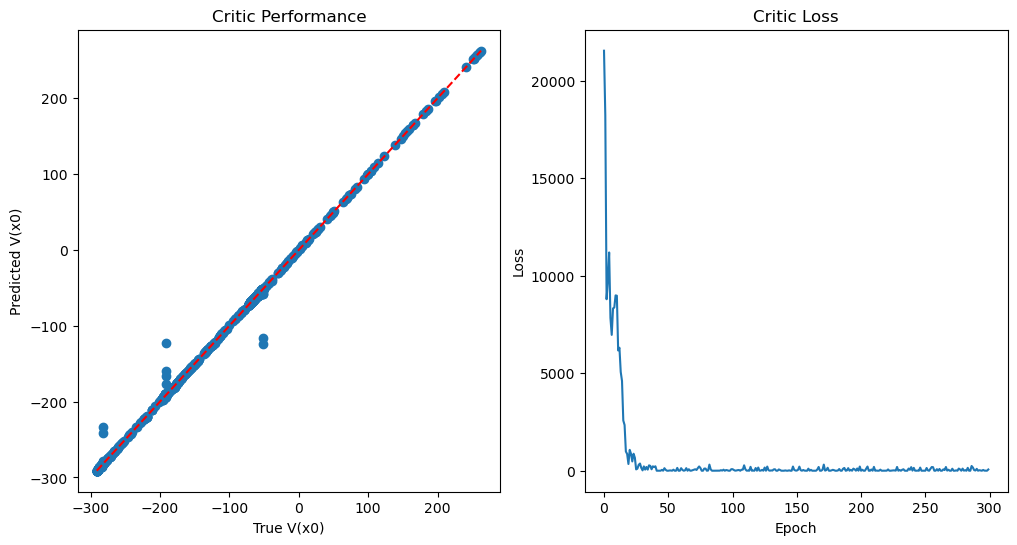

In [8]:
import time

with open(latest_folder + '/training_params.json', 'r') as f:
    training_params = json.load(f)

    version = training_params['version']

    if 'losses' not in training_params:
        losses = None
    else:
        losses = training_params['losses']
    
    if version == -4:
        version = 1
    
    print(f'Evaluating model {version}...')

    # Evaluate inference time
    start_time = time.time()
    V_pred = evalCriticModel(latest_folder, version, test_buffer)
    end_time = time.time()
    print(f'Inference time: {end_time - start_time} seconds')

    # Calulate the mean squared error
    mse = np.mean((V_pred - V_true) ** 2)
    print(f'Mean Squared Error: {mse}')

    plotResults(V_pred, V_true, losses)

Evaluating model 4...
Inference time: 0.005736827850341797 seconds
Mean Squared Error: 4.835898079011003


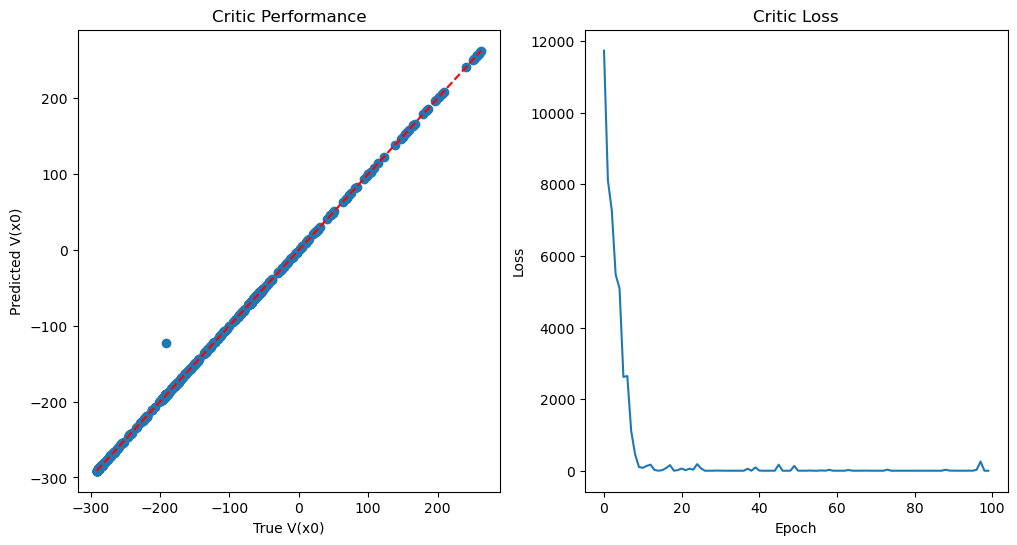

Evaluating model 5...
Inference time: 0.0032830238342285156 seconds
Mean Squared Error: 20.293018329574224


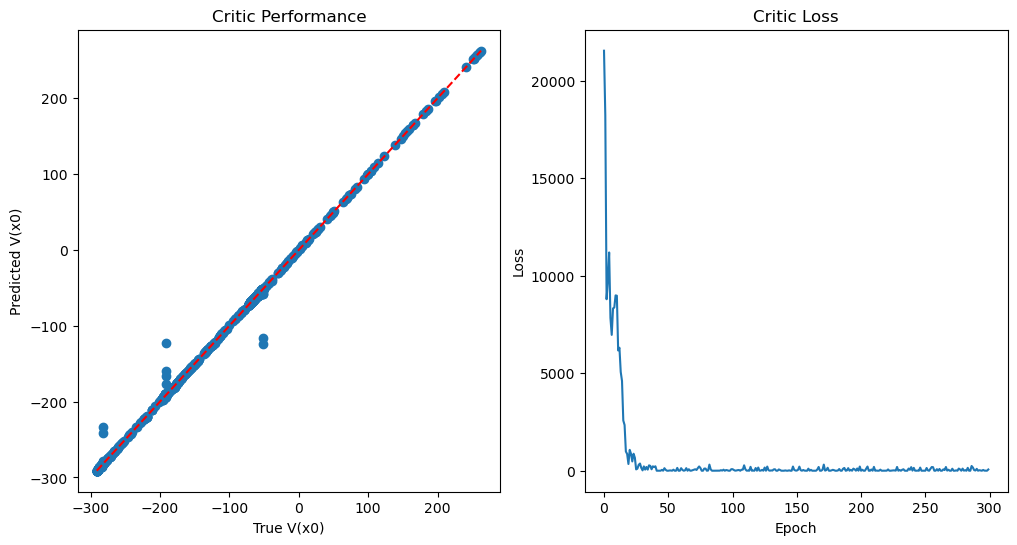

Evaluating model 2...
Inference time: 0.002006053924560547 seconds
Mean Squared Error: 6.059025097667157


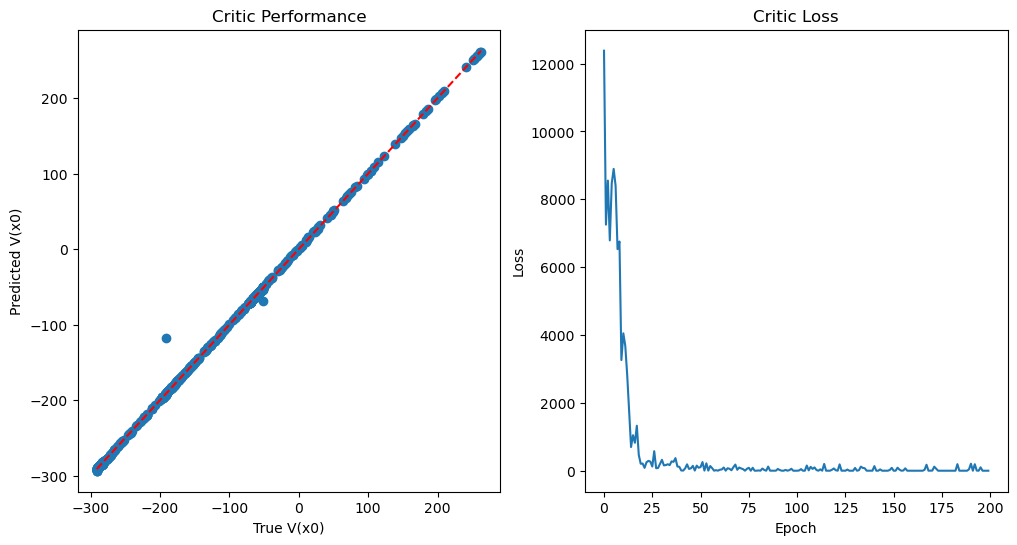

Evaluating model 5...
Inference time: 0.0036394596099853516 seconds
Mean Squared Error: 5.2096304577100305


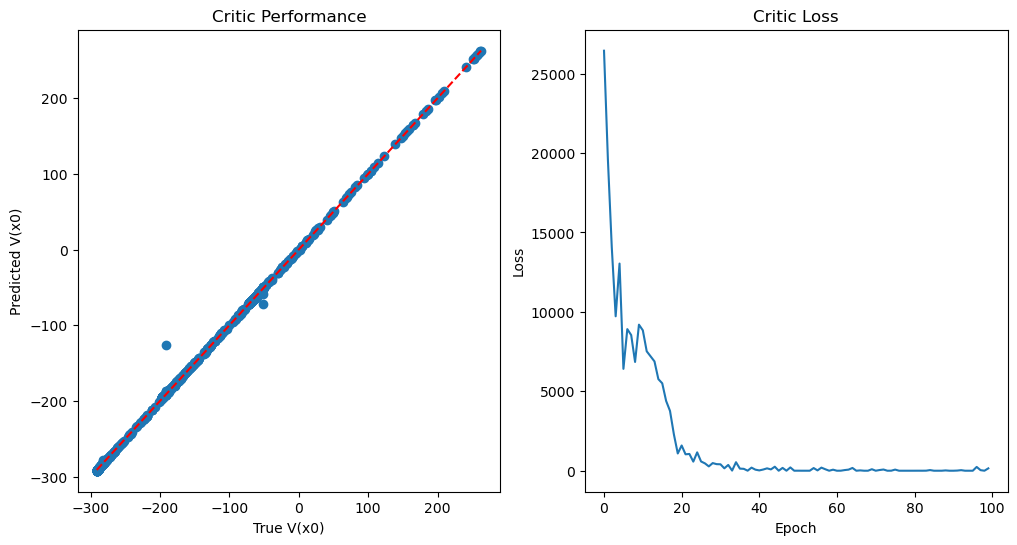

In [9]:
for subdir in subdirs:
    try:
        with open(subdir + '/training_params.json', 'r') as f:
            training_params = json.load(f)

            if 'version' not in training_params:
                continue

            version = training_params['version']

            if 'losses' not in training_params:
                losses = None
            else:
                losses = training_params['losses']
            
            # if version == -4:
            #     version = 1
            # else:
            #     continue
            
            print(f'Evaluating model {version}...')

            # Evaluate inference time
            start_time = time.time()
            V_pred = evalCriticModel(subdir, version, test_buffer)
            end_time = time.time()
            print(f'Inference time: {end_time - start_time} seconds')

            # Calulate the mean squared error
            mse = np.mean((V_pred - V_true) ** 2)
            print(f'Mean Squared Error: {mse}')

            plotResults(V_pred, V_true, losses)
    except:
        pass